In [1]:
from datetime import datetime, timedelta
import pytz
import pandas as pd
from tqdm import tqdm
from modeler.modeler import Modeler as m
from processor.processor import Processor as p
from database.market import Market
from database.sec import SEC
from database.adatabase import ADatabase
from modeler_strats.universal_modeler import UniversalModeler
import numpy as np
import matplotlib.pyplot as plt
import pickle
from functional.backtester import Backtester as b
import math
from statistics import variance

In [2]:
start_date = datetime(2022,1,1)
end_date = datetime.now()

In [3]:
market = Market()
sec = SEC()
fin_db = ADatabase("financial")
earnings_db = ADatabase("earnings")
dividends_db = ADatabase("dividends")
speculation_db = ADatabase("spec")
classification_db = ADatabase("spec_classification")
current_db = ADatabase("financial_current")
umod = UniversalModeler()

In [4]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [5]:
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
bench["day"] = [x.weekday() for x in bench["date"]]
bench_returns = bench.copy()
bench_returns[f"bench_return"] = (bench_returns["adjclose"].shift(-1) - bench_returns["adjclose"].shift(4)) / bench_returns["adjclose"].shift(4)
bench_quarterlies = bench_returns.groupby(["year","quarter"]).agg({"adjclose":"first"}).reset_index().rename(columns={"adjclose":"quarter_start"})
bench_returns = bench_returns.merge(bench_quarterlies,on=["year","quarter"])
bench_returns[f"bench_quarterly_return"] = (bench_returns["adjclose"].shift(-1) - bench_returns["quarter_start"]) / bench_returns["quarter_start"]
bench_returns["variance"] = bench_returns["bench_return"].rolling(window=14).var()
bench_returns["quarterly_variance"] = bench_returns["bench_quarterly_return"].rolling(window=14).var()
bench_returns = bench_returns.dropna()

In [7]:
tyields = pd.read_csv("./csv_files/FED/DGS1.csv")
tyields = p.column_date_processing(tyields)
tyields["dgs1"] = tyields["dgs1"].replace(".",0)
tyields["dgs1"] = tyields["dgs1"].astype("float")
tyields["yield"] = [1+(x/100) for x in tyields["dgs1"]]
tyields["weekly_yield"] = [math.exp(math.log(x)/52) for x in tyields["yield"]]
tyields["quarterly_yield"] = [math.exp(math.log(x)/4) for x in tyields["yield"]]
tyields = tyields.dropna()

In [9]:
financial_factors = ['assets',
 'liabilitiesandstockholdersequity',
 'incometaxexpensebenefit',
 'retainedearningsaccumulateddeficit',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'earningspersharebasic',
 'earningspersharediluted',
 'propertyplantandequipmentnet',
 'cashandcashequivalentsatcarryingvalue',
 'entitycommonstocksharesoutstanding',
 'weightedaveragenumberofdilutedsharesoutstanding',
 'weightedaveragenumberofsharesoutstandingbasic',
 'stockholdersequity']

In [10]:
dividend_factors = ['assets',
 'liabilitiesandstockholdersequity',
 'incometaxexpensebenefit',
 'retainedearningsaccumulateddeficit',
 'accumulatedothercomprehensiveincomelossnetoftax',
 'earningspersharebasic',
 'earningspersharediluted',
 'propertyplantandequipmentnet',
 'cashandcashequivalentsatcarryingvalue',
 'entitycommonstocksharesoutstanding',
 'weightedaveragenumberofdilutedsharesoutstanding',
 'weightedaveragenumberofsharesoutstandingbasic',
 'stockholdersequity',
"commonstockdividendspersharecashpaid"]

In [11]:
classification_factors = []
classification_factors.append("d1")
classification_factors.append("d2")
classification_factors.append("d3")
classification_factors.append("rolling14")

In [12]:
factors = [str(x) for x in range(14)]

In [13]:
included_columns=[
    "year",
    "quarter",
    "week",
    "ticker",
    "adjclose",
    "y"
]
included_columns.extend(factors)
included_columns.extend(classification_factors)
included_columns.extend(financial_factors)
included_columns.extend(dividend_factors)
included_columns = list(set(included_columns))

In [14]:
trades = []
reqs = [0.05]
signals = [0.05]
values = [True]
classifications = [True,False]
ceilings = [True,False]
floors = [True,False]
hedges = [False]
parameters = []
positions = 10
training_year = 4
strats = ["earnings","dividends","financial","sector"]
for strat in strats:
    for value in values:
        for classification in classifications:
            for ceiling in ceilings:
                for floor in floors:
                    for hedge in hedges:
                        for signal in signals:
                            for req in reqs:
                                parameter = {
                                            "value":value
                                             ,"classification":classification
                                             ,"ceiling":ceiling
                                             ,"floor":floor
                                             ,"hedge":hedge
                                             ,"signal":signal
                                             ,"req":req
                                             ,"training_years":training_year
                                            ,"strat":strat
                                            }
                                parameters.append(parameter)

In [15]:
training_sets = []
sec.connect()
market.connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        cik = int(sp500[sp500["ticker"]==ticker]["CIK"])
        prices = market.retrieve_ticker_prices("prices",ticker)
        prices = p.column_date_processing(prices)
        prices["year"] = [x.year for x in prices["date"]]
        prices["quarter"] = [x.quarter for x in prices["date"]]
        filing = sec.retrieve_filing_data(cik)
        filing = p.column_date_processing(filing)
        filing = filing.groupby(["year","quarter"]).mean().reset_index()
        filing["year"] = filing["year"] + 1
        ticker_data = prices[prices["ticker"]==ticker]
        ticker_data.sort_values("date",ascending=True,inplace=True)
        ticker_data["adjclose"] = [float(x) for x in ticker_data["adjclose"]]
        ticker_data = ticker_data.groupby(["year","week"]).mean().reset_index()
        for i in range(14):
            ticker_data[str(i)] = ticker_data["adjclose"].shift(i)
        ticker_data["d1"] = ticker_data["adjclose"].pct_change(periods=1)
        ticker_data["d2"] = ticker_data["d1"].pct_change(periods=1)
        ticker_data["d3"] = ticker_data["d2"].pct_change(periods=1)
        ticker_data["rolling14"] = ticker_data["adjclose"].rolling(window=14).mean()
        ticker_data.dropna(inplace=True)
        ticker_data["ticker"] = ticker
        ticker_data["y"] = ticker_data["adjclose"].shift(-1)
        ticker_data = ticker_data.merge(filing,on=["year","quarter"],how="left").reset_index()
        ticker_data = ticker_data[included_columns]
        training_sets.append(ticker_data)
    except:
        continue
sec.disconnect()
market.disconnect()
data = pd.concat(training_sets).dropna()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [03:10<00:00,  2.57it/s]


In [16]:
market.connect()
sp500 = market.retrieve("sp500")
sp500 = sp500.rename(columns={"Symbol":"ticker"})
market.disconnect()

In [17]:
prediction_slice = data[data["year"]>=start_date.year-2].reset_index(drop=True)
prediction_slice_quarterly = prediction_slice.groupby(["year","quarter","ticker"]).mean().reset_index()

In [18]:
speculation_db.connect()
models = speculation_db.retrieve("models")
speculation_db.disconnect()

In [19]:
fin_db.connect()
financial_models = fin_db.retrieve("models")
fin_db.disconnect()

In [20]:
earnings_db.connect()
earnings_models = earnings_db.retrieve("models")
earnings_db.disconnect()

In [21]:
dividends_db.connect()
dividends_models = dividends_db.retrieve("models")
dividends_db.disconnect()

In [22]:
classification_db.connect()
classification_models = classification_db.retrieve("models")
classification_db.disconnect()

In [23]:
simulation = umod.recommend(models,prediction_slice.copy(),factors)
simulation["week"] = simulation["week"] + 1
simulation["prediction"] = (simulation["cat_prediction"] + simulation["xgb_prediction"] + simulation["tf_prediction"]) / 3

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-03 11:17:12         2522
metadata.json                                  2023-03-03 11:17:12           64
variables.h5                                   2023-03-03 11:17:12        84160
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...metrics\mean
......vars
.........0
.........1
...metrics\mean_absolute_percentage_error
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
368/368 [==============================] - 0s 519us/step


In [24]:
classification_simulation = umod.recommend(classification_models,prediction_slice.copy(),classification_factors)
classification_simulation["week"] = classification_simulation["week"] + 1
classification_simulation["classification_prediction"] = ((classification_simulation["cat_prediction"] + \
                                                          classification_simulation["xgb_prediction"] + \
                                                          classification_simulation["tf_prediction"]) / 3) > 0.5
classification_simulation["classification_prediction"] = [int(x) for x in classification_simulation["classification_prediction"]]

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-15 09:46:40         2141
metadata.json                                  2023-03-15 09:46:40           64
variables.h5                                   2023-03-15 09:46:40        23208
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dropout
......vars
...metrics\mean
......vars
.........0
.........1
...metrics\mean_metric_wrapper
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........2
.........3
.........4
.........5
.........6
.........7
.........8
...vars
368/368 [==============================] - 0s 559us/step


In [25]:
financial_simulation = umod.recommend(financial_models,prediction_slice_quarterly.copy(),financial_factors)
financial_simulation["financial_prediction"] = (financial_simulation["cat_prediction"] + financial_simulation["xgb_prediction"]) / 2

In [26]:
earnings_simulation = umod.recommend(earnings_models,prediction_slice_quarterly.copy(),financial_factors)
earnings_simulation["earnings_prediction"] = (earnings_simulation["cat_prediction"] + earnings_simulation["xgb_prediction"]) / 2

In [27]:
dividends_simulation = umod.recommend(dividends_models,prediction_slice_quarterly.copy(),dividend_factors)
dividends_simulation["dividends_prediction"] = (dividends_simulation["cat_prediction"] + dividends_simulation["xgb_prediction"]) / 2

In [28]:
new_prices = []
market.connect()
for ticker in tqdm(sp500["ticker"].unique()):
    try:
        cik = int(sp500[sp500["ticker"]==ticker]["CIK"])
        financials = sec.retrieve_filing_data(cik)
        financials = p.column_date_processing(financials)
        ticker_sim = market.retrieve_ticker_prices("prices",ticker)
        ticker_sim = p.column_date_processing(ticker_sim)
        ticker_sim = ticker_sim[(ticker_sim["date"]>=(start_date-timedelta(days=365)))]
        for i in range(2,5):
            ticker_sim[f"return_{i}"] = (ticker_sim["adjclose"].shift(-i) - ticker_sim["adjclose"].shift(-1)) / ticker_sim["adjclose"].shift(-1)
        quarterlies = ticker_sim.groupby(["year","quarter"]).agg({"adjclose":"first"}).reset_index().rename(columns={"adjclose":"quarter_start"})
        if "commonstockdividendspersharecashpaid" in financials.columns:
            quarterlies = quarterlies.merge(financials[["year","quarter","commonstockdividendspersharecashpaid"]],how="left")
            quarterlies["commonstockdividendspersharecashpaid"] = quarterlies["commonstockdividendspersharecashpaid"].fillna(0)
        else:
            quarterlies["commonstockdividendspersharecashpaid"] = 0
        ticker_sim = ticker_sim.merge(quarterlies,on=["year","quarter"],how="left")
        ticker_sim["quarterly_return"] =  (ticker_sim["adjclose"].shift(-1) - ticker_sim["quarter_start"]) / ticker_sim["quarter_start"]
        ticker_sim["day"] = [x.weekday() for x in ticker_sim["date"]]
        returns = ticker_sim[ticker_sim["day"]==0]
        returns["weekly_return"] = [row[1]["return_4"] if row[1]["week"] % (13) != 2 else row[1]["return_4"] + row[1]["commonstockdividendspersharecashpaid"] for row in returns.iterrows()]
        new_sim = ticker_sim.merge(returns[["year","week","weekly_return"]], on=["year","week"],how="left") \
                            .merge(bench_returns[["year","week","bench_return","variance","bench_quarterly_return","quarterly_variance"]],on=["year","week"],how="left")
        new_sim = new_sim.dropna()
        new_sim["market_cov"] = new_sim["weekly_return"].rolling(window=100).cov(new_sim["bench_return"])
        new_sim["market_quarterly_cov"] = new_sim["quarterly_return"].rolling(window=100).cov(new_sim["bench_quarterly_return"])
        completed = new_sim.copy()
        completed["beta"] = completed["market_cov"] / completed["variance"]
        completed["quarterly_beta"] = completed["market_quarterly_cov"] / completed["quarterly_variance"]
        completed  = completed.dropna()
        new_prices.append(completed)
    except:
        continue
market.disconnect()
price_returns = pd.concat(new_prices)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [03:03<00:00,  2.67it/s]


In [38]:
sim = price_returns.merge(simulation.drop("adjclose",axis=1)[["year","week","ticker","prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(classification_simulation.drop(["adjclose","training_years"],axis=1,errors="ignore")[["year","week","ticker","classification_prediction"]],on=["year","week","ticker"],how="left") \
                    .merge(tyields[["date","weekly_yield","quarterly_yield"]],on="date",how="left") \
                    .merge(financial_simulation[["year","quarter","ticker","financial_prediction"]],on=["year","quarter","ticker"],how="left") \
                    .merge(earnings_simulation[["year","quarter","ticker","earnings_prediction"]],on=["year","quarter","ticker"],how="left") \
                    .merge(dividends_simulation[["year","quarter","ticker","dividends_prediction"]],on=["year","quarter","ticker"],how="left")

In [40]:
ranks = sim.merge(sp500[["ticker","GICS Sector"]],how="left").groupby(["year","quarter","GICS Sector"]).mean().reset_index().sort_values(["year","quarter","return_4"],ascending=False).groupby(["year","quarter"]).first().reset_index().rename(columns={"GICS Sector":"top_sector"})[["year","quarter","top_sector"]]
ranks["year"] = ranks["year"] + 1

In [41]:
sim["projected_return"] = (sim["prediction"] - sim["adjclose"]) / sim["adjclose"]
sim["delta"] = [abs(x) for x in sim["projected_return"]]
sim["delta_sign"] = [1 if x >= 0 else -1 for x in sim["projected_return"]]
sim["market_return"] = math.exp(np.log(1.15)/52)
sim["market_quarterly_return"] = math.exp(np.log(1.15)/4)
sim["rrr"] = sim["weekly_yield"] + sim["beta"] * (sim["market_return"] - sim["weekly_yield"]) - 1
sim = sim.groupby(["date","ticker"]).mean().reset_index()
sim.sort_values("date",inplace=True)

In [45]:
current_db.connect()
current_db.drop("trades")
for parameter in tqdm(parameters):
    simulation = sim.copy()
    strat = parameter["strat"]
    if strat == "dividend":
        simulation["projected_quarterly_return"] = (simulation[f"dividends_prediction"] - simulation["adjclose"]) / simulation["adjclose"]
    else:
        simulation["projected_quarterly_return"] = (simulation[f"financial_prediction"] - simulation["adjclose"]) / simulation["adjclose"]
    simulation["quarterly_delta"] = [abs(x) for x in simulation["projected_quarterly_return"]]
    simulation["quarterly_delta_sign"] = [1 if x >= 0 else -1 for x in simulation["projected_quarterly_return"]]
    simulation["quarterly_rrr"] = simulation["quarterly_yield"] + simulation["quarterly_beta"] * (simulation["market_quarterly_return"] - simulation["quarterly_yield"]) - 1
    simulation["projected_pe"] = simulation["financial_prediction"] / simulation["earnings_prediction"]
    if strat == "earnings":
        industry_filter = []
        for industry in sp500["GICS Sector"].unique():
            tickers = list(sp500[sp500["GICS Sector"]==industry]["ticker"])
            industry_simulation = simulation[simulation["ticker"].isin(tickers)]
            filtered = industry_simulation[(industry_simulation["projected_pe"] <= industry_simulation["projected_pe"].mean()) & (industry_simulation["projected_pe"] > 0)]
            industry_filter.append(filtered)
        simulation = pd.concat(industry_filter)
    if strat == "sector":
        simulation = simulation.merge(ranks,on=["year","quarter"],how="left").merge(sp500[["ticker","GICS Sector"]],how="left")
        simulation["go_industry"] = simulation["GICS Sector"] == simulation["top_sector"]
        simulation = simulation[simulation["go_industry"]==True]
    b.experimental_backtest(simulation.copy(),parameter,start_date,end_date,current_db)
current_db.disconnect()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:38<00:00,  3.07s/it]


In [61]:
earnings_simulation.sort_values(["year","quarter"])

,year,quarter,ticker,10,8,d1,liabilitiesandstockholdersequity,4,retainedearningsaccumulateddeficit,earningspersharediluted,...,9,5,7,incometaxexpensebenefit,adjclose,xgb_prediction,xgb_score,cat_prediction,cat_score,earnings_prediction
0,2020,1.0,A,79.546523,81.340863,-0.014977,8.746500e+09,82.845664,-1.230000e+08,0.290000,...,80.624587,83.025020,81.924607,1.485000e+08,79.292557,0.586382,0.891972,-1524.798050,-0.001667,-762.105834
1,2020,1.0,ABBV,73.862926,74.797680,-0.017046,6.506900e+10,76.402551,4.413500e+09,1.587273,...,74.514078,76.292790,75.118811,1.286333e+09,74.150682,2.851327,0.891972,-24.915163,-0.001667,-11.031918
2,2020,1.0,ABC,82.400020,82.892092,-0.004880,3.846883e+10,84.639976,3.873900e+09,2.870000,...,82.766740,84.480880,83.230928,-2.310155e+08,84.135696,0.881811,0.891972,-12446.826081,-0.001667,-6222.972135
3,2020,1.0,ADI,107.663094,108.876892,-0.019054,2.112935e+10,110.200067,6.236855e+09,0.865000,...,108.539553,110.207568,108.988118,6.352350e+07,104.365881,0.800392,0.891972,4975.003483,-0.001667,2487.901938
4,2020,1.0,AEE,69.365541,69.950930,-0.006809,1.719300e+10,72.682431,1.637500e+09,1.237273,...,69.626438,72.038565,70.540837,1.991667e+08,72.958448,1.954390,0.891972,1182.974552,-0.001667,592.464471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
938,2023,1.0,WRB,72.451466,72.020667,-0.012071,3.034666e+10,70.328725,8.681758e+09,3.936667,...,72.450257,70.933899,71.730208,1.975473e+08,67.100275,3.649652,0.891972,-261.983434,-0.001667,-129.166891
939,2023,1.0,WRK,35.589026,36.085565,-0.011767,2.916840e+10,34.836848,1.659550e+09,0.625000,...,35.889208,35.219770,35.898219,5.445000e+07,32.949853,0.538810,0.891972,1634.692443,-0.001667,817.615626
940,2023,1.0,WY,30.372421,30.915651,-0.002096,1.698150e+10,31.223593,1.271000e+09,1.480000,...,30.552421,31.198434,31.108182,2.523333e+08,30.961496,1.059103,0.891972,-4112.546483,-0.001667,-2055.743690
941,2023,1.0,WYNN,81.002750,87.090750,0.022529,1.320019e+10,96.693942,-1.910249e+09,-8.286667,...,84.366750,94.484250,89.650288,2.473283e+08,104.310288,-9.699533,0.891972,-8384.276956,-0.001667,-4196.988244


In [46]:
current_db.connect()
t = current_db.retrieve("trades")
current_db.disconnect()

In [47]:
t = t.fillna(1)

In [62]:
analysis = []
indexer = list(parameters[0].keys())
for parameter in parameters:
    try:
        ledger = t.sort_values(["year","week"])
        for key in parameter.keys():
            ledger = ledger[ledger[key]==parameter[key]]
        portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
        counted_columns = [x for x in range(ledger["position"].max()+1)]
        for col in range(positions):
            if col not in counted_columns:
                portfolio[col] = 1
        counted_columns = [x for x in range(positions)]
        cumulative = portfolio[[i for i in counted_columns]].cumprod()
        cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
        cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
        cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
        cumulative = cumulative.merge(bench_returns[["date","adjclose","bench_return","variance"]],on="date",how="left")
        cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
        cumulative["return"] = cumulative["pv"].pct_change().fillna(1)
        cumulative["beta"] = cumulative[["return","bench_return"]].cov().iloc[0][1]/cumulative["variance"].iloc[-1]
        cumulative["rrr"] = tyields["yield"].iloc[-1] + cumulative["beta"].iloc[-1]*(cumulative["bench"].iloc[-1]-tyields["yield"].iloc[-1])
        cumulative["sharpe"] = (cumulative["pv"] - tyields["yield"].iloc[-1]) / cumulative["beta"].iloc[-1]
        for index_stuff in indexer:
            cumulative[index_stuff] = parameter[index_stuff]
        analysis.append(cumulative[indexer + ["pv","beta","rrr","sharpe"]].iloc[-1])
    except Exception as e:
        print(str(e))
        continue
a = pd.DataFrame(analysis)

In [63]:
a.sort_values("pv",ascending=False)

,value,classification,ceiling,floor,hedge,signal,req,training_years,strat,pv,beta,rrr,sharpe
29,True,False,True,False,False,0.05,0.05,4,earnings,1.122220,-0.382162,1.108118,-0.188454
29,True,False,False,False,False,0.05,0.05,4,earnings,1.122220,-0.382162,1.108118,-0.188454
29,True,False,True,True,False,0.05,0.05,4,earnings,1.112203,-0.366517,1.105747,-0.169169
29,True,False,False,True,False,0.05,0.05,4,earnings,1.112203,-0.366517,1.105747,-0.169169
28,True,True,True,False,False,0.05,0.05,4,earnings,1.084002,-0.446352,1.117846,-0.075730
28,True,True,False,False,False,0.05,0.05,4,earnings,1.084002,-0.446352,1.117846,-0.075730
28,True,True,True,True,False,0.05,0.05,4,earnings,1.078920,-0.435227,1.116160,-0.065989
28,True,True,False,True,False,0.05,0.05,4,earnings,1.078920,-0.435227,1.116160,-0.065989
37,True,True,False,True,False,0.05,0.05,4,sector,1.015447,-0.520124,1.129026,0.066817
39,True,False,False,True,False,0.05,0.05,4,sector,1.013187,-0.521799,1.129280,0.070934


In [64]:
a.sort_values("pv",ascending=False).groupby("strat").first().reset_index().sort_values("pv")

,strat,value,classification,ceiling,floor,hedge,signal,req,training_years,pv,beta,rrr,sharpe
0,dividends,True,True,True,True,False,0.05,0.05,4,0.984191,-0.398311,1.110565,0.165722
2,financial,True,True,True,True,False,0.05,0.05,4,0.984191,-0.398311,1.110565,0.165722
3,sector,True,True,False,True,False,0.05,0.05,4,1.015447,-0.520124,1.129026,0.066817
1,earnings,True,False,True,False,False,0.05,0.05,4,1.122220,-0.382162,1.108118,-0.188454


In [65]:
top = a.sort_values("pv",ascending=False).iloc[0]
analysis = t.copy()
for key in parameter.keys():
    analysis = analysis[(analysis[key]==top[key])]
ledger = analysis[["year","week","ticker","delta","actual_returns","position"]]
ledger = ledger.merge(sp500[["ticker","GICS Sector","Security"]],on="ticker",how="left")

In [66]:
t.columns

Index(['year', 'week', 'ticker', 'delta_sign', 'quarterly_delta', 'delta',
       'returns', 'floored_returns', 'position', 'actual_returns', 'value',
       'classification', 'ceiling', 'floor', 'hedge', 'signal', 'req',
       'training_years', 'strat'],
      dtype='object')

In [67]:
ledger.sort_values(["week","position"]).to_csv("current.csv")

In [68]:
portfolio = ledger.pivot_table(index=["year","week"],columns="position",values="actual_returns").fillna(1).reset_index()
counted_columns = [x for x in range(ledger["position"].max()+1)]
for col in range(positions):
    if col not in counted_columns:
        portfolio[col] = 1
portfolio.reset_index()

position,index,year,week,0,1,2,3,4,5,6,7,8,9
0,0,2022.0,2.0,0.973764,0.961099,0.954773,1.012836,0.993769,1.010085,1.000000,1.000000,1,1
1,1,2022.0,4.0,0.983173,0.973051,1.036493,0.988244,0.985969,1.026555,1.035320,1.025753,1,1
2,2,2022.0,5.0,1.029973,0.953724,1.018370,0.968918,0.991335,1.011953,0.969498,1.054443,1,1
3,3,2022.0,6.0,0.952326,0.975764,1.030496,0.966765,0.976959,1.019707,1.000000,1.000000,1,1
4,4,2022.0,7.0,1.003430,1.029047,0.956980,0.911744,1.000783,1.003995,1.032308,1.000000,1,1
5,5,2022.0,9.0,0.992253,0.995468,1.043428,1.021660,0.986781,1.016080,1.000000,1.000000,1,1
6,6,2022.0,10.0,1.008085,0.963167,0.993465,0.969650,1.057940,1.018047,1.013686,1.000000,1,1
7,7,2022.0,11.0,1.145713,1.079945,1.024357,1.045149,1.024833,0.989474,1.000000,1.000000,1,1
8,8,2022.0,12.0,0.994781,0.960496,0.998583,0.986016,1.034959,0.982256,1.000000,1.000000,1,1
9,9,2022.0,13.0,1.030604,1.046751,1.028323,1.013700,1.013567,0.991610,1.000000,1.000000,1,1


In [69]:
counted_columns

[0, 1, 2, 3, 4, 5, 6, 7]

In [70]:
counted_columns = [x for x in range(positions)]
cumulative = portfolio[[i for i in counted_columns]].cumprod()
cumulative["date_string"] = [f'{int(row[1]["year"])}-W{int(row[1]["week"])}' for row in portfolio.iterrows()]
cumulative["date"] = [datetime.strptime(x + '-1', '%G-W%V-%u') for x in cumulative["date_string"]]
cumulative["pv"] = [sum([row[1][column] * 0.1 for column in counted_columns]) for row in cumulative.iterrows()]
bench = pd.read_csv("./csv_files/FED/SPY.csv")
bench = p.column_date_processing(bench)
cumulative = cumulative.merge(bench[["date","adjclose"]],on="date",how="left")
cumulative["bench"] = [1 + (row[1]["adjclose"] - cumulative["adjclose"].iloc[0]) / cumulative["adjclose"].iloc[0] for row in cumulative.iterrows()]
cumulative

,0,1,2,3,4,5,6,7,8,9,date_string,date,pv,adjclose,bench
0,0.973764,0.961099,0.954773,1.012836,0.993769,1.010085,1.000000,1.000000,1,1,2022-W2,2022-01-10,0.990633,455.562408,1.000000
1,0.957378,0.935199,0.989616,1.000929,0.979825,1.036908,1.035320,1.025753,1,1,2022-W4,2022-01-24,0.996093,433.241119,0.951003
2,0.986074,0.891922,1.007795,0.969818,0.971335,1.049302,1.003740,1.081598,1,1,2022-W5,2022-01-31,0.996158,439.858063,0.965528
3,0.939064,0.870305,1.038529,0.937586,0.948955,1.069980,1.003740,1.081598,1,1,2022-W6,2022-02-07,0.988976,431.780457,0.947797
4,0.942285,0.895585,0.993851,0.854838,0.949697,1.074255,1.036169,1.081598,1,1,2022-W7,2022-02-14,0.982828,425.673248,0.934391
5,0.934985,0.891527,1.037012,0.873354,0.937144,1.091529,1.036169,1.081598,1,1,2022-W9,2022-02-28,0.988332,423.653839,0.929958
6,0.942544,0.858689,1.030235,0.846847,0.991442,1.111228,1.050350,1.081598,1,1,2022-W10,2022-03-07,0.991293,411.792267,0.903921
7,1.079886,0.927337,1.055329,0.885081,1.016062,1.099531,1.050350,1.081598,1,1,2022-W11,2022-03-14,1.019517,435.760468,0.956533
8,1.074249,0.890703,1.053834,0.872704,1.051582,1.080021,1.050350,1.081598,1,1,2022-W12,2022-03-21,1.015504,445.148102,0.977140
9,1.107126,0.932345,1.083681,0.884660,1.065849,1.070960,1.050350,1.081598,1,1,2022-W13,2022-03-28,1.027657,445.374268,0.977636


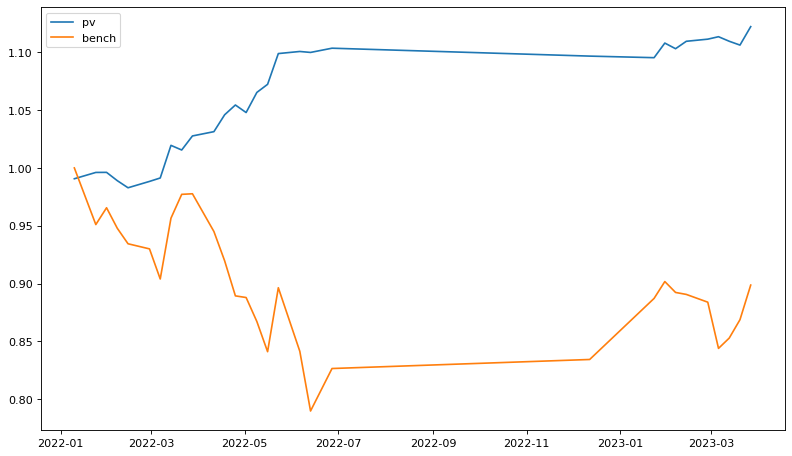

In [71]:
plt.figure(figsize=(12, 7), dpi=80)
plt.plot(cumulative["date"],cumulative["pv"])
plt.plot(cumulative["date"],cumulative["bench"])
plt.legend(["pv","bench"])

In [72]:
industry_analysis = ledger.pivot_table(index=["year","week"],columns="GICS Sector",values="actual_returns").fillna(1).reset_index()
industry_analysis[[x for x in industry_analysis.columns if x not in  ["year","week"]]].cumprod()

GICS Sector,Consumer Discretionary,Financials,Information Technology,Real Estate
0,0.954773,0.977434,1.011460,0.973764
1,0.935210,1.007674,1.028483,0.957378
2,0.906413,0.979992,1.061521,0.974965
3,0.884987,1.009878,1.039865,0.974965
4,0.899629,1.013912,0.995551,1.003286
5,0.891645,1.035874,1.012728,1.003286
6,0.878828,1.050164,1.021234,1.003286
7,0.953560,1.086614,1.056968,1.003286
8,0.915890,1.085075,1.056442,1.003286
9,0.928438,1.097127,1.087657,1.003286
